In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from collections import Counter

In [34]:
df = pd.read_csv('winequality-red.csv')

In [35]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


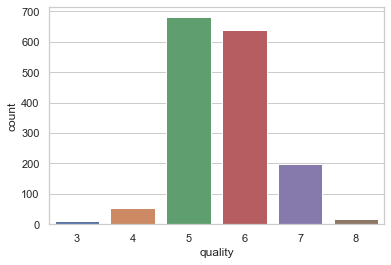

In [36]:
sns.countplot(x=df.quality);

In [37]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

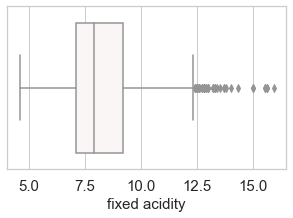

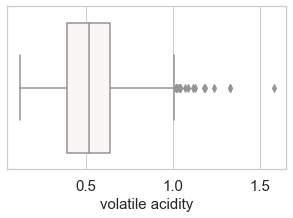

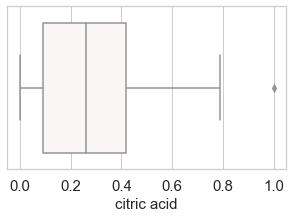

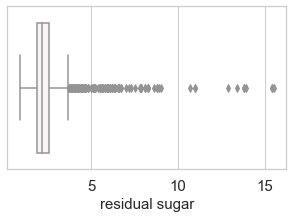

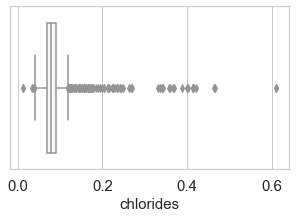

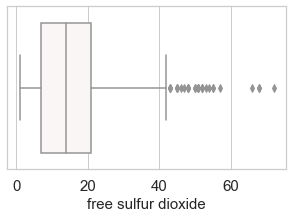

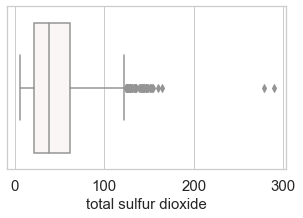

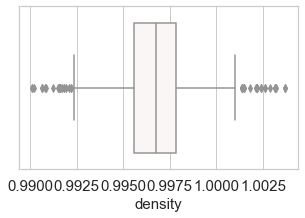

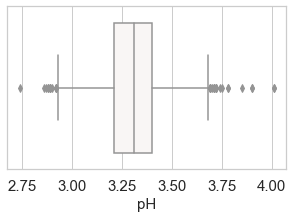

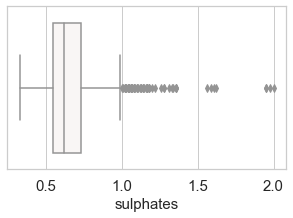

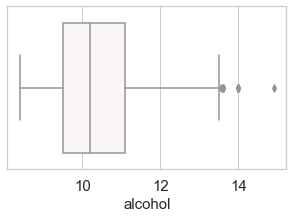

In [38]:
# Boxploty

sns.set_theme(style="whitegrid")

list_columns = list(df.drop("quality", axis=1).columns)

for column in list_columns:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

### Podział na zbiór treningowy i testowy

In [75]:
# Podział na zbiór treningowy i testowy

X = df.drop("quality", axis=1)
y = df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = df.quality, random_state=0)
y_train.value_counts()

5    477
6    446
7    139
4     37
8     13
3      7
Name: quality, dtype: int64

### Oversampling / Undersampling

In [41]:
# instantiating over and under sampler
over_strategy = {3: 177, 4: 177, 8: 177}                      # 50% średniej z 3 najliczniejszych klas
over = RandomOverSampler(sampling_strategy=over_strategy)
under_strategy = {5: 382, 6: 357}                             # 80% wartości każdej z dwóch najliczniejszych klas
under = RandomUnderSampler(sampling_strategy=under_strategy)

# first performing oversampling to minority class
X_over, y_over = over.fit_resample(X_train, y_train)
print(f"Oversampled: {Counter(y_over)}")

# now to comine under sampling 
X_combined, y_combined = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_combined)}")

Oversampled: Counter({5: 477, 6: 446, 8: 177, 4: 177, 3: 177, 7: 139})
Combined Random Sampling: Counter({5: 382, 6: 357, 3: 177, 4: 177, 8: 177, 7: 139})


In [42]:
y_combined.value_counts()

5    382
6    357
3    177
4    177
8    177
7    139
Name: quality, dtype: int64

### Usuwanie outlier'ów

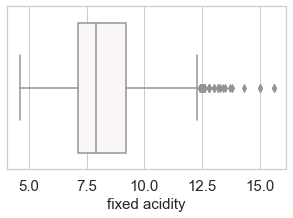

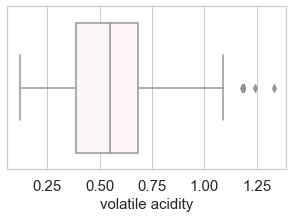

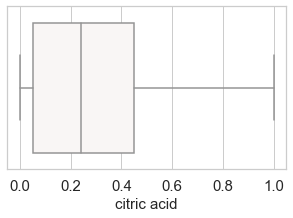

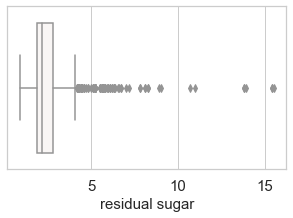

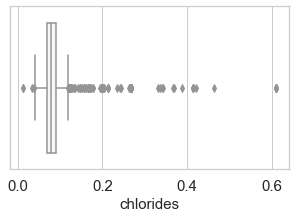

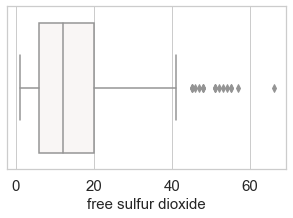

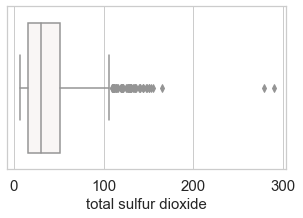

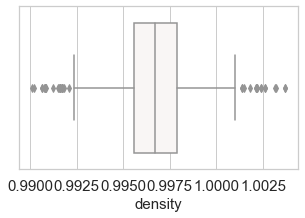

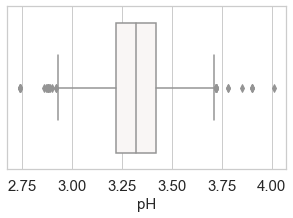

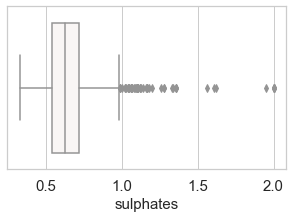

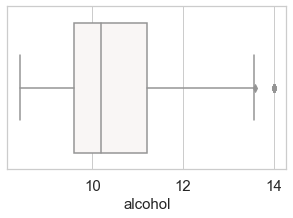

In [43]:
# Boxploty przed usunięciem outlier'ów

sns.set_theme(style="whitegrid")

list_columns_comb = list(X_combined.columns)

for column in list_columns_comb:
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=X_combined[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [51]:
# Usuwanie outlier'ów z zestawu treningowego

def drop_outliers(dff, column):
    iqr = np.percentile(dff[column], 75) - np.percentile(dff[column], 25)
    dff.drop(dff[dff[column] < np.percentile(dff[column], 25) - 3.0 * iqr].index, inplace=True)
    dff.drop(dff[dff[column] > np.percentile(dff[column], 75) + 3.0 * iqr].index, inplace=True)
    return dff

In [52]:
df_train = pd.concat([X_combined, y_combined], axis=1)
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.7,0.760,0.02,1.80,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3
1,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3
2,7.1,0.875,0.05,5.70,0.082,3.0,14.0,0.99808,3.40,0.52,10.20,3
3,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.00,3
4,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.70,3


In [53]:
df_train.shape

(1409, 12)

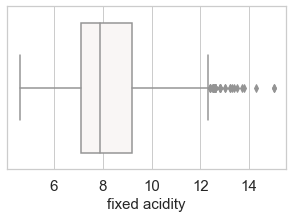

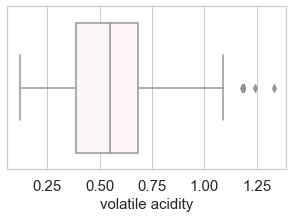

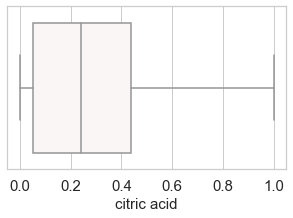

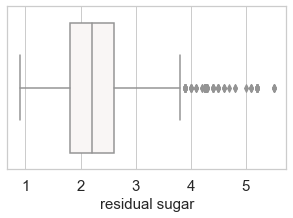

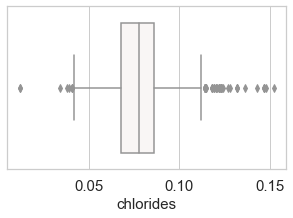

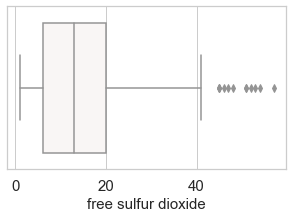

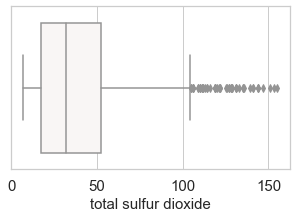

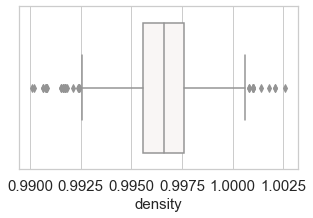

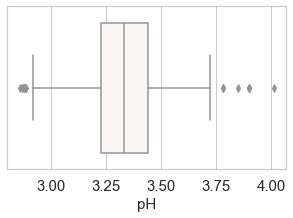

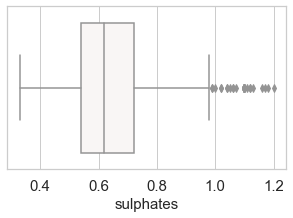

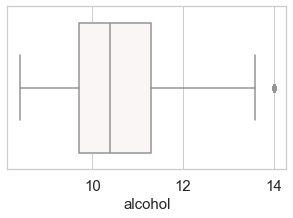

In [54]:
# Boxploty po usunięciu outlier'ów

for column in list_columns:
    drop_outliers(df_train, column=column)
    
    f, ax = plt.subplots(figsize=(5, 3))
    sns.boxplot(x=df_train[column], palette="vlag")
    ax.set_xlabel(column,fontsize=15)
    ax.tick_params(labelsize=15);

In [55]:
df_train.shape

(1240, 12)

In [76]:
X_train_outlier = df_train.drop("quality", axis=1)
y_train_outlier = df_train.quality

y_train_outlier.value_counts()

5    341
6    331
8    177
4    157
7    125
3    109
Name: quality, dtype: int64

In [62]:
# Usuwanie outlier'ów z zestawu testowego (z wykorzystaniem iqr i percentyli z zestawu treningowego)

def drop_outliers_test(df_train, df_test, column):
    iqr = np.percentile(df_train[column], 75) - np.percentile(df_train[column], 25)
    df_test.drop(df_test[df_test[column] < np.percentile(df_train[column], 25) - 3.0 * iqr].index, inplace=True)
    df_test.drop(df_test[df_test[column] > np.percentile(df_train[column], 75) + 3.0 * iqr].index, inplace=True)
    return df_test

In [63]:
# Sprawdzenie przed usunięciem

y_test.value_counts()

5    204
6    192
7     60
4     16
8      5
3      3
Name: quality, dtype: int64

In [64]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
435,12.3,0.39,0.63,2.30,0.091,6.0,18.0,1.00040,3.16,0.49,9.5,5
125,9.0,0.62,0.04,1.90,0.146,27.0,90.0,0.99840,3.16,0.70,9.4,5
1245,7.4,0.55,0.19,1.80,0.082,15.0,34.0,0.99655,3.49,0.68,10.5,5
721,8.9,0.48,0.24,2.85,0.094,35.0,106.0,0.99820,3.10,0.53,9.2,5
289,11.6,0.42,0.53,3.30,0.105,33.0,98.0,1.00100,3.20,0.95,9.2,5


In [67]:
df_test.shape

(480, 12)

In [66]:
df_train_2 = pd.concat([X_combined, y_combined], axis=1)
df_train_2.shape

(1409, 12)

In [69]:
for column in list_columns:
    drop_outliers_test(df_train_2, df_test, column=column)

In [70]:
# Sprawdzenie po usunięciu

df_test.shape

(442, 12)

In [71]:
X_test_outlier = df_test.drop("quality", axis=1)
y_test_outlier = df_test.quality

y_test_outlier.value_counts()

### Normalizacja

In [73]:
# Normalizacja zestawu treningowego do rozkładu normalnego, wyznaczenie wartości średnich i odchyleń standardowych
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

scaler = StandardScaler()
scaler.fit(X_train_outlier)

X_train_std = scaler.transform(X_train_outlier)

print(scaler.mean_, scaler.scale_)

[ 8.25274194  0.55929435  0.25376613  2.41822581  0.07856694 14.72419355
 40.51935484  0.99659029  3.3356129   0.64523387 10.62454301] [1.69749119e+00 2.23502197e-01 2.04735691e-01 7.98336525e-01
 1.63362462e-02 9.76521452e+00 2.89629217e+01 1.85793783e-03
 1.60609560e-01 1.41605233e-01 1.16702079e+00]


In [74]:
# Normalizacja zestawu testowego do rozkładu normalnego z wykorzystaniem wartości średnich i odch. std z zestawu treningowego

X_test_std = scaler.transform(X_test_outlier)